In [30]:
#!pip install matplotlib
#!pip install pandas
#!pip install sqlalchemy
#!pip install json
#!pip install os


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/opt/homebrew/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [5]:
import pandas as pd
from sqlalchemy import create_engine
import os
import json
import ast
from db_connection import engine 


#### Explore Exchange Rates Table

* There are 4 currency in the data set
* Time frame covered = '2022-01-01' to '2023-12-31'
* We can use this table directly in the sql for the report creation to convert from sell_currency to EUR 
* Revenue * IFNULL(Rate,1.0) = [currency]_revenue for any conversion 
* in the report case we will want only the `buyer_currency` EUR
* Future proofing we will create a python script that will pip install all necessary packages so the user only need python installed and the db_connection.py file in same location
* User will be able to pull 'all' or only a particular month's report via a python response of user
* granted we could also set up a sql query with filters in a visualization tool that would be much easier for Business Stakeholders. Else this works and can be adjusted for formatting for finance for exporting particular clients invoices and such. 
* Standing question? I see 4, however what if transactions are not in Euro but also not on the exchange_rate table. 
- ALL 3 to Euro are present in the exchange rate table for now. 
- Would be good to put in a try:  in the final report to alert of issue. 

In [6]:
query = "SELECT * FROM exchange_rates"

exchange_rates = pd.read_sql_query(query, engine)
print(exchange_rates.head())
print(" ")
print('Uniqueness of the data set:')
print(exchange_rates.nunique())
print(" ")
print('Timframe Covered')
print("Min date: ", exchange_rates['date'].min())
print("Max date: ", exchange_rates['date'].max())




         date sell_currency buy_currency       rate
0  2022-01-01           DKK          SEK   1.509188
1  2022-01-01           DKK          GBP   0.114865
2  2022-01-01           DKK          EUR   0.134026
3  2022-01-01           EUR          SEK  11.187020
4  2022-01-01           EUR          DKK   7.461202
 
Uniqueness of the data set:
date              730
sell_currency       4
buy_currency        4
rate             7922
dtype: int64
 
Timframe Covered
Min date:  2022-01-01
Max date:  2023-12-31


In [7]:
print('Unique currency')
print('Sell Currency: ', exchange_rates['sell_currency'].unique())
print('Buy Currency: ', exchange_rates['buy_currency'].unique())
print("")
# Select the columns 'sell_currency' and 'buy_currency'
unique_combos = exchange_rates[['sell_currency', 'buy_currency']].drop_duplicates()

# Print the unique combinations
print('Combos of currency: ', unique_combos)


Unique currency
Sell Currency:  ['DKK' 'EUR' 'GBP' 'SEK']
Buy Currency:  ['SEK' 'GBP' 'EUR' 'DKK']

Combos of currency:     sell_currency buy_currency
0            DKK          SEK
1            DKK          GBP
2            DKK          EUR
3            EUR          SEK
4            EUR          DKK
5            EUR          GBP
6            GBP          DKK
7            GBP          EUR
8            GBP          SEK
9            SEK          DKK
10           SEK          GBP
11           SEK          EUR


#### Explore transactions / Monthly Report

In [8]:
query = """SELECT booked_time::DATE as booked_date,
currency,
SUM(revenue) as revenue
FROM transactions
GROUP BY 1,2
"""

transactions = pd.read_sql_query(query, engine)

transactions.head()


,booked_date,currency,revenue
0,2023-04-16,GBP,318.57
1,2023-05-05,GBP,314.09
2,2023-06-01,EUR,200.42
3,2023-04-16,DKK,349.62
4,2023-04-07,EUR,466.29


In [9]:
transactions.describe()

,revenue
count,1915.000000
mean,222.800031
std,151.906754
min,0.040000
25%,26.500000
50%,261.920000
75%,346.165000
max,559.960000


In [10]:
print('Timeframe of data set')
print( 'min date: ', transactions['booked_date'].min())
print( 'max date: ', transactions['booked_date'].max())

Timeframe of data set
min date:  2022-01-30
max date:  2023-12-31


#### Explore Line Items

* Transactions are ID is unique primary key
* Details of transactions will need to expanded for exploratory work
* Name appears to be the actual product, quantity is the number ordered, total_price was the price for quantity * product price
* Stakeholder wants to know - Analyse the basket size of transactions to give insights on amounts spent by customer over time.
     - Explore Type of products, average price
     - Basket size (require looking a the sum of transactions) - Number of products, average basket size, 
     - popularity of product 
     - Time line if we combine the transactions table we may gain insist on forecasting  future sales or trends (Seasonal,TimeSeries)

In [11]:
query = "SELECT * FROM line_items"

line_items = pd.read_sql_query(query, engine)
line_items.head()

,id,transaction_id,details
0,05275e2c-6096-40a5-b440-2ca233661dd8,e3ba488a-2419-4c3b-9c3c-6f8f559f0ed5,"{'name': 'Lightweight Rubber Pants', 'quantity..."
1,55f1315f-5ab7-4130-994f-a54a66a23088,e3ba488a-2419-4c3b-9c3c-6f8f559f0ed5,"{'name': 'Jean Poole', 'quantity': 9, 'total_p..."
2,c26d878e-6bfb-4de3-8da3-510854900138,5706cb41-2877-4d76-ac7d-caf63d951328,"{'name': 'Heavy Duty Cotton Knife', 'quantity'..."
3,02d8224e-0208-4ca3-aa0b-bbfb34424c62,5706cb41-2877-4d76-ac7d-caf63d951328,"{'name': 'Incredible Rubber Shoes', 'quantity'..."
4,b2015611-9985-4e4e-8eb3-c953d764d21a,5706cb41-2877-4d76-ac7d-caf63d951328,"{'name': 'Marcus Absent', 'quantity': 5, 'tota..."


In [12]:
# Normalize the 'details' column
details_df = pd.json_normalize(line_items['details'])

# Concatenate the line_items with the normalized details DataFrame
line_items = pd.concat([line_items.drop(columns=['details']), details_df], axis=1)

line_items.head()

,id,transaction_id,name,quantity,total_price
0,05275e2c-6096-40a5-b440-2ca233661dd8,e3ba488a-2419-4c3b-9c3c-6f8f559f0ed5,Lightweight Rubber Pants,4,110.35
1,55f1315f-5ab7-4130-994f-a54a66a23088,e3ba488a-2419-4c3b-9c3c-6f8f559f0ed5,Jean Poole,9,878.56
2,c26d878e-6bfb-4de3-8da3-510854900138,5706cb41-2877-4d76-ac7d-caf63d951328,Heavy Duty Cotton Knife,9,400.61
3,02d8224e-0208-4ca3-aa0b-bbfb34424c62,5706cb41-2877-4d76-ac7d-caf63d951328,Incredible Rubber Shoes,2,329.62
4,b2015611-9985-4e4e-8eb3-c953d764d21a,5706cb41-2877-4d76-ac7d-caf63d951328,Marcus Absent,5,159.43


#### Import and Explore Bank Export

* Bank report surprisingly coming in as date, currency and amount... How come we are not getting a transactional report? 
* All 4 currency are present 
* Mean, and Min are drastically different than the transaction table despite almost the same amount of lines when aggregated to day/currency
* 2024-01-01 is the max date; however max date for  transaction table is 2023-12-31; which means the file is missing the last month of data. 
* 

In [13]:
bank_export = pd.read_csv('code-challenge-analytics/input-data/bank_export.csv')
bank_export.head()

,currency,date,amount
0,GBP,2022-01-30,988.91
1,GBP,2022-05-09,733.37
2,GBP,2022-05-16,699.39
3,GBP,2022-05-11,290.73
4,GBP,2022-05-25,516.44


In [14]:
bank_export.nunique()
print('Unique Currency',bank_export['currency'].unique())

Unique Currency ['GBP' 'EUR' 'DKK' 'SEK']


In [15]:
bank_export.describe()

,amount
count,1921.000000
mean,40384.369328
std,27565.359927
min,15.570000
25%,4821.590000
50%,47564.340000
75%,62999.160000
max,95863.630000


In [16]:
print('Timeframe of data set')
print( 'min date: ', bank_export['date'].min())
print( 'max date: ', bank_export['date'].max())

Timeframe of data set
min date:  2022-01-30
max date:  2024-01-01


## Investigate Bank Report and Transactions

* Transactions are  by 4 currency and so is Bank Report; Assumption I should retain the currencies in the reports
* Bank is per day/ currency...do the same for transactions
* The CSV doesn't have a datetime, as per our injestion... whithout this context we are just assuming the datetime were normalized to the same datetime as our database is in. 
* Already I see transactions has 1915 lines versus bankexport has 1921 which means there seems to be missing data from the transactions. 

In [17]:
# Ensure date columns are of the same type
bank_export['date'] = pd.to_datetime(bank_export['date'])
transactions['booked_date'] = pd.to_datetime(transactions['booked_date'])

# Merge the DataFrames
merged_data = pd.merge(bank_export, transactions, left_on=['currency', 'date'], right_on=['currency', 'booked_date'], how='outer')

merged_data.head()

,currency,date,amount,booked_date,revenue
0,DKK,2022-05-20,430.16,2022-05-20,2.41
1,DKK,2022-05-26,372.08,2022-05-26,1.54
2,DKK,2022-06-11,772.59,2022-06-11,2.53
3,DKK,2022-06-15,591.94,2022-06-15,5.82
4,DKK,2022-06-16,441.01,NaT,NaN


In [18]:
# How many NaN are there? 
print(merged_data.isnull().sum())

# Is there more dates null other than Jan 2024?  - There are  14 more days missing other than Jan 2024
print(merged_data[merged_data['date'] < '2024-01-01'].isnull().sum())

currency        0
date           12
amount         12
booked_date    18
revenue        18
dtype: int64
currency        0
date            0
amount          0
booked_date    14
revenue        14
dtype: int64


In [19]:
# Where is Bank missing? 
print('Bank Transactions Missing: ',  merged_data['date'].isna().sum())
print(merged_data[merged_data['date'].isna() == True])
print("")

# Where is the company missing data? 
print('Company Transactions missing: ', merged_data['booked_date'].isna().sum())
print(merged_data[merged_data['booked_date'].isna() == True]['date'].unique())
print("")

Bank Transactions Missing:  12
     currency date  amount booked_date  revenue
19        DKK  NaT     NaN  2022-08-11     5.36
482       EUR  NaT     NaN  2022-05-27     1.50
488       EUR  NaT     NaN  2022-07-06     1.19
498       EUR  NaT     NaN  2022-07-29     3.53
518       EUR  NaT     NaN  2022-09-08     7.06
1018      GBP  NaT     NaN  2022-09-30     0.49
1446      SEK  NaT     NaN  2022-06-28     2.12
1468      SEK  NaT     NaN  2022-08-17     5.02
1472      SEK  NaT     NaN  2022-08-21     1.83
1477      SEK  NaT     NaN  2022-08-28     2.52
1494      SEK  NaT     NaN  2022-09-18     1.80
1531      SEK  NaT     NaN  2022-10-26     7.18

Company Transactions missing:  18
<DatetimeArray>
['2022-06-16 00:00:00', '2022-09-05 00:00:00', '2022-09-24 00:00:00',
 '2024-01-01 00:00:00', '2022-05-28 00:00:00', '2022-07-07 00:00:00',
 '2022-07-30 00:00:00', '2022-09-09 00:00:00', '2022-09-14 00:00:00',
 '2022-09-03 00:00:00', '2022-09-16 00:00:00', '2022-11-08 00:00:00',
 '2022-08-05 0

* The bank data is missng 12 dates in 2022
* The company side is missing 18 dates from 2022 and all of 2024

In [20]:
#  where are the largest mismatches? 
# Convert column B to datetime, specify format if necessary
merged_data['date'] = pd.to_datetime(merged_data['date'], errors='coerce')  # 'coerce' will set invalid parsing to NaT (Not a Time)
merged_data['booked_date'] = pd.to_datetime(merged_data['booked_date'], errors='coerce')  # 'coerce' will set invalid parsing to NaT (Not a Time)

# replace missing data with 0 so I can compare
merged_data['coalesced_date'] = merged_data['date'].fillna(merged_data['booked_date']) 
merged_data.fillna(0, inplace=True)


# Calculate the difference between the amounts in the two tables
merged_data['amount_difference'] = merged_data['amount'] - merged_data['revenue']

merged_data.head()

/var/folders/dk/psx0q4qx07x65m41mmwmgj1c0000gp/T/ipykernel_94804/825895033.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  merged_data.fillna(0, inplace=True)


,currency,date,amount,booked_date,revenue,coalesced_date,amount_difference
0,DKK,2022-05-20 00:00:00,430.16,2022-05-20 00:00:00,2.41,2022-05-20,427.75
1,DKK,2022-05-26 00:00:00,372.08,2022-05-26 00:00:00,1.54,2022-05-26,370.54
2,DKK,2022-06-11 00:00:00,772.59,2022-06-11 00:00:00,2.53,2022-06-11,770.06
3,DKK,2022-06-15 00:00:00,591.94,2022-06-15 00:00:00,5.82,2022-06-15,586.12
4,DKK,2022-06-16 00:00:00,441.01,0,0.00,2022-06-16,441.01


In [21]:
print('Are there missing dates: ', merged_data['coalesced_date'].isnull().sum())

# Ensure date columns are of datetime type
merged_data['coalesced_date'] = pd.to_datetime(merged_data['coalesced_date'], errors='coerce')  # 'coerce' will set invalid parsing to NaT (Not a Time)
merged_data.head()

Are there missing dates:  0


,currency,date,amount,booked_date,revenue,coalesced_date,amount_difference
0,DKK,2022-05-20 00:00:00,430.16,2022-05-20 00:00:00,2.41,2022-05-20,427.75
1,DKK,2022-05-26 00:00:00,372.08,2022-05-26 00:00:00,1.54,2022-05-26,370.54
2,DKK,2022-06-11 00:00:00,772.59,2022-06-11 00:00:00,2.53,2022-06-11,770.06
3,DKK,2022-06-15 00:00:00,591.94,2022-06-15 00:00:00,5.82,2022-06-15,586.12
4,DKK,2022-06-16 00:00:00,441.01,0,0.00,2022-06-16,441.01


* Looks from understanding 2022 has alignment issue this is across the board for all currencies. 
* Revenue is a fraction of the amount reported in the bank report. As described the company only recieves a % of the transaction amount is that what is being recorded? 
    * if yes, we should look into  furture proofing investigations with the transaction, % and final revenue amount the company recieved. 

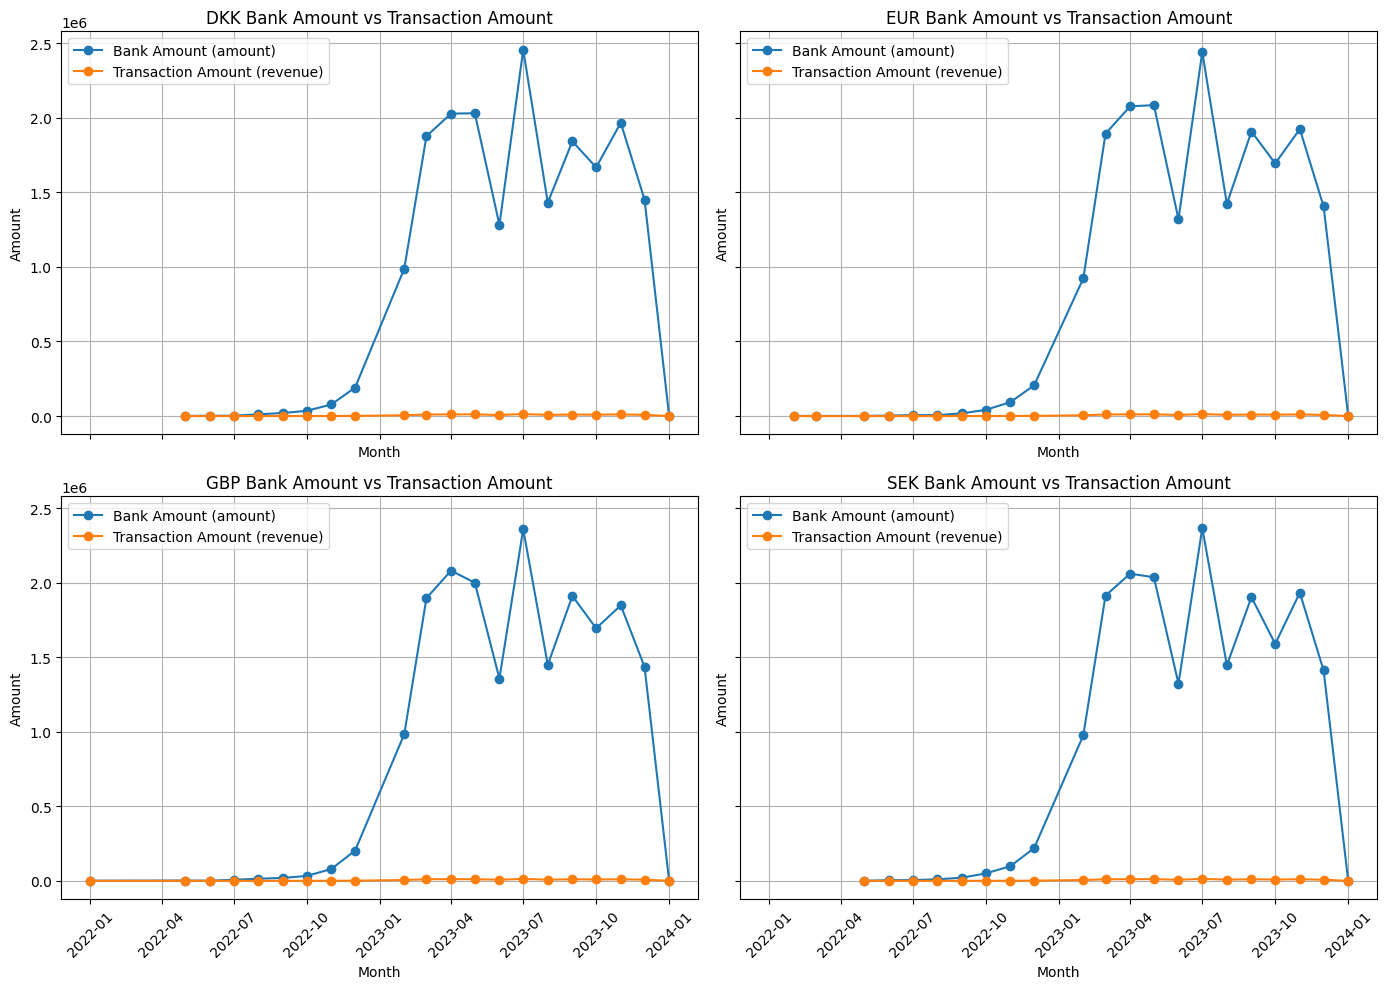

In [22]:
# Plot the difference over time 

import matplotlib.pyplot as plt


# Aggregate the data per month and currency
merged_data['month'] = merged_data['coalesced_date'].dt.to_period('M')
aggregated_df = merged_data.groupby(['currency', 'month']).agg({'amount': 'sum', 'revenue': 'sum'}).reset_index()

# Convert 'month' back to datetime for plotting
aggregated_df['month'] = aggregated_df['month'].dt.to_timestamp()

# Plotting the data
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
currencies = aggregated_df['currency'].unique()

# Create subplots for each currency
for i, currency in enumerate(currencies):
    ax = axs[i // 2, i % 2]
    currency_data = aggregated_df[aggregated_df['currency'] == currency]
    ax.plot(currency_data['month'], currency_data['amount'], marker='o', label='Bank Amount (amount)')
    ax.plot(currency_data['month'], currency_data['revenue'], marker='o', label='Transaction Amount (revenue)')
    ax.set_title(f'{currency} Bank Amount vs Transaction Amount')
    ax.set_xlabel('Month')
    ax.set_ylabel('Amount')
    ax.legend()
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

In [23]:

# Create 'month' column for grouping
bank_export['year'] = bank_export['date'].dt.to_period('y')

# Count entries per month and currency
count_per_year = bank_export.groupby(['currency', 'year']).size().reset_index(name='entry_count')

# Display the count of entries per month and currency
print(count_per_year)

   currency  year  entry_count
0       DKK  2022          141
1       DKK  2023          334
2       DKK  2024            1
3       EUR  2022          144
4       EUR  2023          334
5       EUR  2024            1
6       GBP  2022          142
7       GBP  2023          334
8       GBP  2024            1
9       SEK  2022          154
10      SEK  2023          334
11      SEK  2024            1


/var/folders/dk/psx0q4qx07x65m41mmwmgj1c0000gp/T/ipykernel_94804/3065395538.py:2: FutureWarning: 'y' is deprecated and will be removed in a future version, please use 'Y' instead.
  bank_export['year'] = bank_export['date'].dt.to_period('y')


In [27]:
# How does this compare to the transactions table? 
# Create 'month' column for grouping
transactions['year'] = transactions['booked_date'].dt.to_period('y')

# Count entries per month and currency
count_per_month = transactions.groupby(['currency', 'year']).size().reset_index(name='entry_count')

# Display the count of entries per month and currency
print(count_per_month)

  currency  year  entry_count
0      DKK  2022          139
1      DKK  2023          334
2      EUR  2022          143
3      EUR  2023          334
4      GBP  2022          140
5      GBP  2023          334
6      SEK  2022          157
7      SEK  2023          334


/var/folders/dk/psx0q4qx07x65m41mmwmgj1c0000gp/T/ipykernel_89699/510152142.py:3: FutureWarning: 'y' is deprecated and will be removed in a future version, please use 'Y' instead.
  transactions['year'] = transactions['booked_date'].dt.to_period('y')


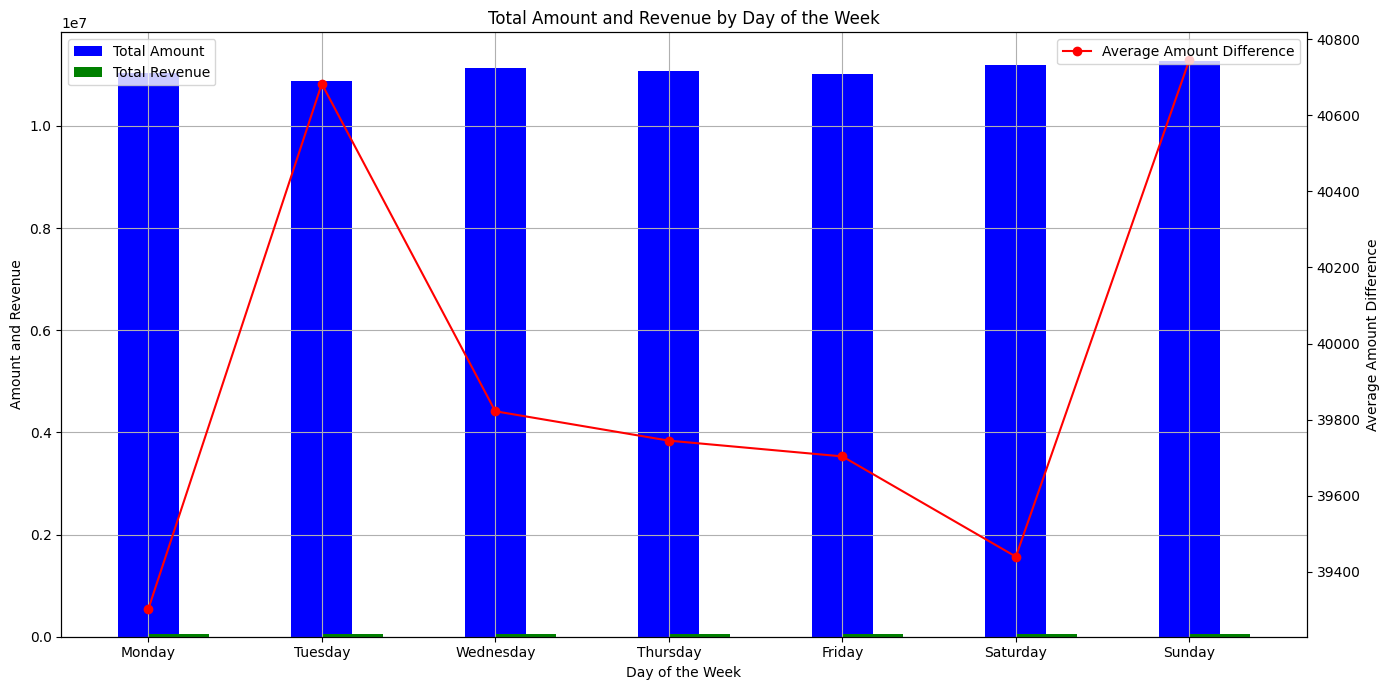

In [24]:
# How does this look over time? Specific Days of week, Month ....

# Extract the day of the week
merged_data['day_of_week'] = merged_data['coalesced_date'].dt.day_name()

# Aggregate the data per day of the week
aggregated_df = merged_data.groupby('day_of_week').agg({
    'amount': 'sum',
    'revenue': 'sum',
    'amount_difference': 'mean'
}).reset_index()

# Order the days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
aggregated_df['day_of_week'] = pd.Categorical(aggregated_df['day_of_week'], categories=days_order, ordered=True)
aggregated_df = aggregated_df.sort_values('day_of_week')

# Plotting the data
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot summed amount and revenue as bar plots
bar_width = 0.35
bar1 = ax1.bar(aggregated_df['day_of_week'], aggregated_df['amount'], width=bar_width, label='Total Amount', color='blue', align='center')
bar2 = ax1.bar(aggregated_df['day_of_week'], aggregated_df['revenue'], width=bar_width, label='Total Revenue', color='green', align='edge')

# Adding titles and labels
ax1.set_xlabel('Day of the Week')
ax1.set_ylabel('Amount and Revenue')
ax1.set_title('Total Amount and Revenue by Day of the Week')
ax1.legend(loc='upper left')

# Create secondary y-axis for average amount_difference
ax2 = ax1.twinx()
ax2.plot(aggregated_df['day_of_week'], aggregated_df['amount_difference'], color='red', marker='o', label='Average Amount Difference')
ax2.set_ylabel('Average Amount Difference')

# Adding legends and grid
ax2.legend(loc='upper right')
ax1.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

* Looks like the avearge difference is pretty high no matter a particular day in 40K though Tues and Sunday, have higher differences.  
* even going back to early 2022 there is a drastic difference; is the revenue correlated with % the company takes? 

In [25]:
# Are there specific days with higher discrepancy resulting in the average being much higher? -- almost all dates are off

merged_data[merged_data['amount_difference'] > 0].count()


currency             1921
date                 1921
amount               1921
booked_date          1921
revenue              1921
coalesced_date       1921
amount_difference    1921
month                1921
day_of_week          1921
dtype: int64

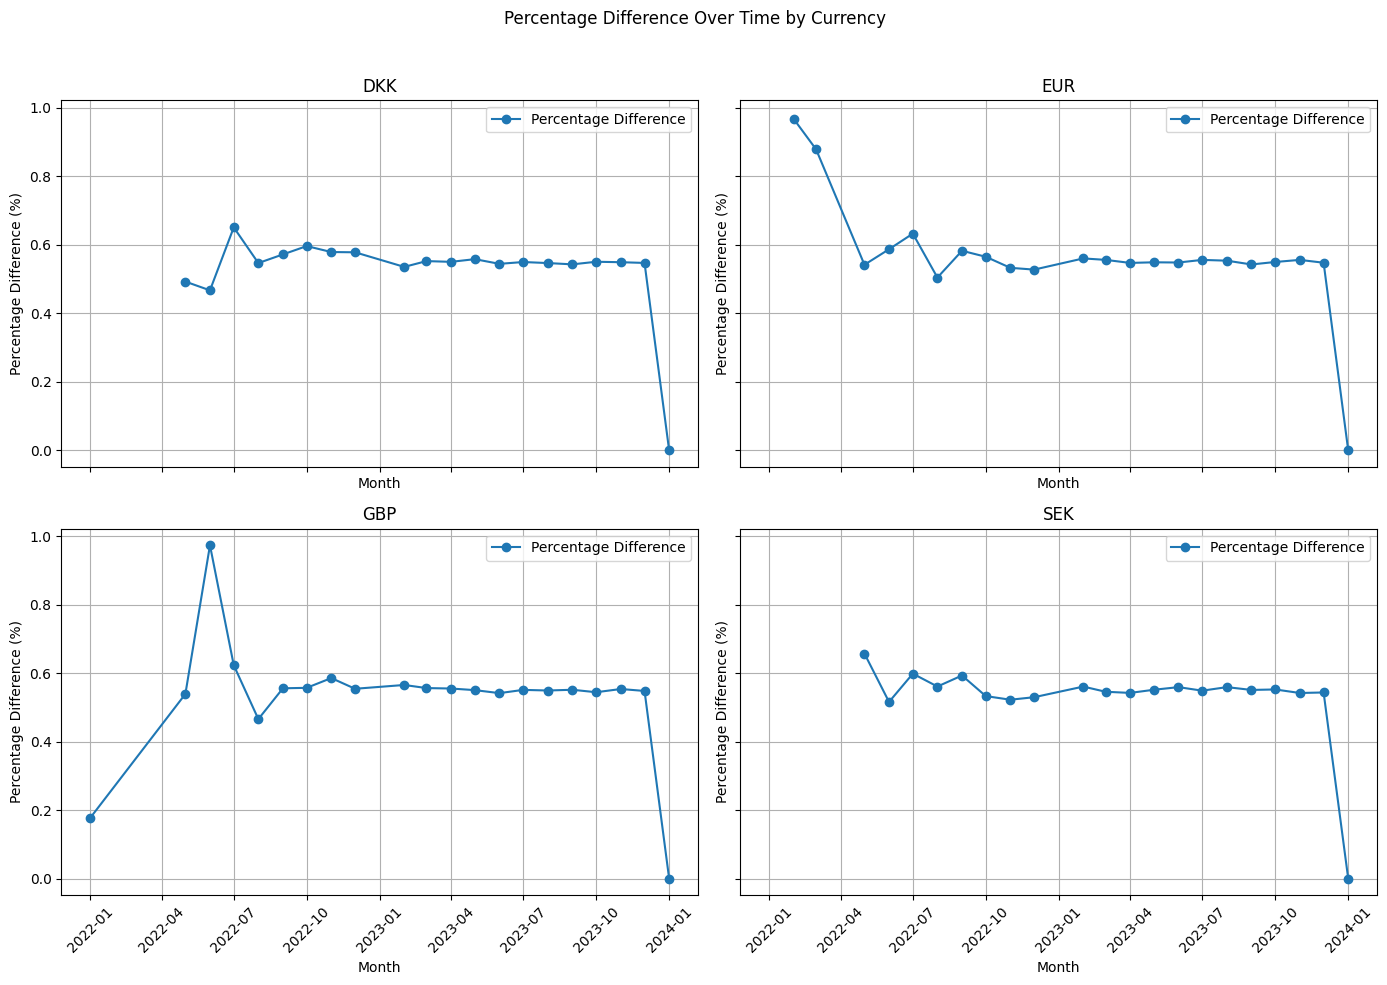

In [26]:
#Correlation of amount ver bank is this the % from the company gets or the actual transactional amount?


# Aggregate data per month and currency
monthly_data = merged_data.groupby(['currency', 'month']).agg({'amount': 'sum', 'revenue': 'sum'}).reset_index()

# Calculate percentage difference per month
monthly_data['per_amount_revenue'] = (monthly_data['revenue'] / monthly_data['amount']) * 100

# Convert 'month' to timestamp for plotting
monthly_data['month'] = monthly_data['month'].dt.to_timestamp()

# Plotting the data
currencies = monthly_data['currency'].unique()
num_currencies = len(currencies)

# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
fig.suptitle('Percentage Difference Over Time by Currency')

# Plot each currency in the grid
for i, currency in enumerate(currencies):
    ax = axs[i // 2, i % 2]
    currency_data = monthly_data[monthly_data['currency'] == currency]
    ax.plot(currency_data['month'], currency_data['per_amount_revenue'], marker='o', label='Percentage Difference')
    ax.set_title(f'{currency}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Percentage Difference (%)')
    ax.legend()
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)

    

# Hide any empty subplots
for j in range(i + 1, 4):
    fig.delaxes(axs[j // 2, j % 2])

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

* The graphs above suggest the `revenue` from transactions is the companies % of bank sales.
* We don't have all the transactions bank in 2022 making it look like we were exact instead of a percentage we typically see around 0.5%


In [29]:
# What day of week are the missing dates
print('Bank Transactions Missing: ',  merged_data['date'].isna().sum())
print(merged_data[merged_data['date'] == 0])
print("")

Bank Transactions Missing:  0
     currency date  amount          booked_date  revenue coalesced_date  \
19        DKK    0     0.0  2022-08-11 00:00:00     5.36     2022-08-11   
482       EUR    0     0.0  2022-05-27 00:00:00     1.50     2022-05-27   
488       EUR    0     0.0  2022-07-06 00:00:00     1.19     2022-07-06   
498       EUR    0     0.0  2022-07-29 00:00:00     3.53     2022-07-29   
518       EUR    0     0.0  2022-09-08 00:00:00     7.06     2022-09-08   
1018      GBP    0     0.0  2022-09-30 00:00:00     0.49     2022-09-30   
1446      SEK    0     0.0  2022-06-28 00:00:00     2.12     2022-06-28   
1468      SEK    0     0.0  2022-08-17 00:00:00     5.02     2022-08-17   
1472      SEK    0     0.0  2022-08-21 00:00:00     1.83     2022-08-21   
1477      SEK    0     0.0  2022-08-28 00:00:00     2.52     2022-08-28   
1494      SEK    0     0.0  2022-09-18 00:00:00     1.80     2022-09-18   
1531      SEK    0     0.0  2022-10-26 00:00:00     7.18     2022-10-2